In [41]:
import xgboost as xgb
import pandas as pd
import numpy as np
from datetime import timedelta
import dataframe_image as dfi
import matplotlib.pyplot as plt
import sklearn.metrics as mtr
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

pd.options.display.max_colwidth = 200

In [42]:
df = pd.read_csv("../Bases/Cleaned/rota33642_weather.csv")

df["data_partida"] = pd.to_datetime(df["data_partida"])

df = df.sort_values(by=["data_partida"], ascending=True)

df["tempo_viagem_1"] = df["tempo_viagem"]
df["tempo_viagem_2"] = df["tempo_viagem"]
df["tempo_viagem_3"] = df["tempo_viagem"]

df["tempo_viagem_1"] = df["tempo_viagem_1"].shift(1)
df["tempo_viagem_2"] = df["tempo_viagem_2"].shift(2)
df["tempo_viagem_3"] = df["tempo_viagem_3"].shift(3)
df

,data_partida,tempo_viagem,dia_semana,partidaTimeStamp,qtdDiasAno,tipo_dia,turno_dia,hora_dia,Precipitacao,Umidade,Vento,Temperatura,Descricao Chuva,Calor,tempo_viagem_1,tempo_viagem_2,tempo_viagem_3
9313,2019-07-01 04:24:03,703,1,1561965843,182,1,1,4,0.0,62,0.3,19.35,0,1,NaN,NaN,NaN
9312,2019-07-01 04:49:57,801,1,1561967397,182,1,1,4,0.0,66,0.1,18.80,0,1,703.0,NaN,NaN
9311,2019-07-01 04:58:33,781,1,1561967913,182,1,1,4,0.0,66,0.1,18.80,0,1,801.0,703.0,NaN
9310,2019-07-01 05:07:10,781,1,1561968430,182,1,2,5,0.0,66,0.1,18.80,0,1,781.0,801.0,703.0
9309,2019-07-01 05:16:42,787,1,1561969002,182,1,2,5,0.0,66,0.1,18.80,0,1,781.0,781.0,801.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2019-09-30 23:30:14,993,1,1569897014,273,1,4,23,0.0,77,2.9,16.70,0,1,1573.0,930.0,1063.0
3,2019-09-30 23:46:49,824,1,1569898009,273,1,4,23,0.0,77,2.9,16.70,0,1,993.0,1573.0,930.0
2,2019-10-01 00:00:45,852,2,1569898845,274,1,1,0,0.0,77,2.9,16.70,0,1,824.0,993.0,1573.0
1,2019-10-01 00:16:27,849,2,1569899787,274,1,1,0,0.0,77,2.9,16.70,0,1,852.0,824.0,993.0


In [43]:
df.groupby(['Calor']).size()

Calor
0    3303
1    4767
2    1244
dtype: int64

In [44]:

data_atual = df["data_partida"].dt.date.min() + timedelta(days=42)


df_teste = df[df["data_partida"].dt.date > data_atual]
df_treino = df[df["data_partida"].dt.date <= data_atual]


x_teste = df_teste[["partidaTimeStamp", "dia_semana", "tipo_dia", "hora_dia", "turno_dia",'Descricao Chuva','tempo_viagem_1','tempo_viagem_2','tempo_viagem_3']]
y_teste = df_teste["tempo_viagem"]
x_treino = df_treino[["partidaTimeStamp", "dia_semana", "tipo_dia", "hora_dia", "turno_dia",'Descricao Chuva','tempo_viagem_1','tempo_viagem_2','tempo_viagem_3']]
y_treino = df_treino["tempo_viagem"]

        

# Hyperparâmetros do XGBoosting
params_xgb = {
        "n_estimators": list(range(100, 1100, 100)), #Number of gradient boosted trees. Equivalent to number of boosting rounds
        "max_depth": list(range(2, 15)),#Maximum tree depth for base learners.
        "min_child_weight": list(range(1, 11)),#Minimum sum of instance weight(hessian) needed in a child.
        "learning_rate": [0.3, 0.2, 0.1, 0.05, 0.01, 0.005],#Boosting learning rate (xgb’s “eta”)
        "gamma": np.arange(0, 0.7, 0.1)#Minimum loss reduction required to make a further partition on a leaf node of the tree.
        }



#Criação e fit do modelo XGB
modelo_xgb = xgb.XGBRegressor(early_stop_rounds = 100)
xgb_rand_search = RandomizedSearchCV(modelo_xgb, params_xgb, scoring="neg_mean_squared_error", n_iter=40, verbose=True, cv=10, n_jobs=-1, random_state=123)
xgb_rand_search.fit(x_treino, y_treino)
modelo_xgb = xgb_rand_search.best_estimator_

modelo_xgb.fit(x_treino, y_treino, eval_set = [(x_treino, y_treino)])

df_teste["predicao_xgb"] = modelo_xgb.predict(x_teste)




Fitting 10 folds for each of 40 candidates, totalling 400 fits
[21:04:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stop_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:04:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stop_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:1178.13934
[1]	validation_0-rmse:1172.39195
[2]	validation_0-rm

C:\Users\Thiago\AppData\Local\Temp\ipykernel_7204\665291872.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste["predicao_xgb"] = modelo_xgb.predict(x_teste)


<AxesSubplot: title={'center': 'Importância Dados'}>

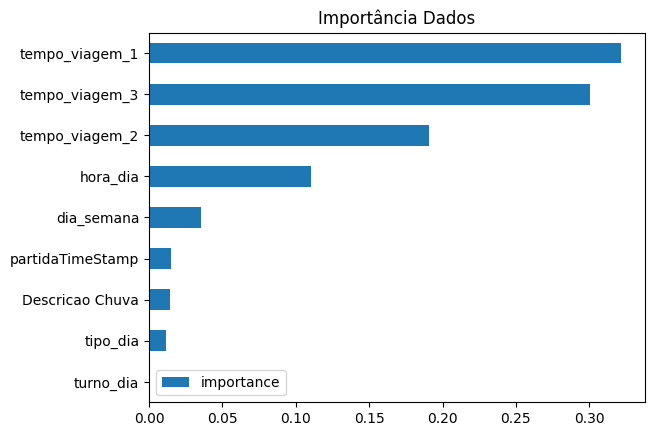

In [45]:
fi_rf = pd.DataFrame(data=modelo_xgb.feature_importances_, index=modelo_xgb.feature_names_in_, columns=["importance"])
fi_rf.sort_values("importance").plot(kind="barh", title=f"Importância Dados")

In [46]:
RRSE_xgb = np.sqrt(sum((df_teste["tempo_viagem"] - df_teste["predicao_xgb"]) ** 2) / sum((df_teste["tempo_viagem"] - np.mean(df_teste["tempo_viagem"])) ** 2))
RMSE_xgb = mtr.mean_squared_error(df_teste["tempo_viagem"], df_teste["predicao_xgb"], squared=False) 
MAPE_xgb = mtr.mean_absolute_percentage_error(df_teste["tempo_viagem"], df_teste["predicao_xgb"])

print(RRSE_xgb)
print(RMSE_xgb)
print(MAPE_xgb)

0.6802842730558216
158.88845407291006
0.10320234226475347
